In [1]:
import dask
import dask.dataframe as ddf
import os
from glob import glob
import re
import pandas as pd
import numpy as np
import time
import pickle
import json
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import _pickle as cPickle

/usr/lib/python3/dist-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
controversial_title_dir = '../../../mount-files/controversial_titles/'

In [3]:
all_title_files = glob(controversial_title_dir + '*')

In [5]:
metric_path = '../../../mount-files/all-data-extracted-page-info/'

In [6]:
all_files = glob(metric_path + '*')

# get all controversial articles info

In [8]:
talks = []
for i in all_title_files:
    with open(i, 'rb') as f:
        c_titles = pickle.load(f)
        talks += c_titles

In [9]:
# get corresponding article pages
articles = list(map(lambda x: str(x).replace('Talk:', ''), talks))

In [10]:
controversial_articles = articles + talks

In [13]:
with open('../../result/' + 'controversial_articles.txt', "wb") as fp:   #Pickling
    pickle.dump(controversial_articles, fp)

In [ ]:
# read all folders
# for controversial articles, get all metrics, and append it to a csv file

In [15]:
for file in all_files:
    test = ddf.read_parquet(os.path.join(file,'revision.count')).compute()
    test = test.loc[test.index.isin(controversial_articles)]
    if test.empty:
        continue
    test = test.join(ddf.read_parquet(os.path.join(file,'page.length')).compute())
    test = test.join(ddf.read_parquet(os.path.join(file,'unique.editors')).compute())
    test = test.join(ddf.read_parquet(os.path.join(file,'links.count')).compute())
    test = test.join(ddf.read_parquet(os.path.join(file,'anon.edits')).compute())
    test = test.join(ddf.read_parquet(os.path.join(file,'minor')).compute())
    test = test.join(ddf.read_parquet(os.path.join(file,'reverts_new')).compute())
    test = test.join(ddf.read_parquet(os.path.join(file,'crc')).compute())   
    test.to_csv('../../intermediate-result/controversial_articles.csv', mode='a', header=False)

In [ ]:
# convert the csv to pandas

In [16]:
data = pd.read_csv('../../intermediate-result/controversial_articles.csv',names=['revision.count','page.length','unique.editors','links.count','anon.edits',
                                                       'minor','reverts','crc'])

In [18]:
# merge article and talk pages
# rename metrics for talk pages (add prefix 'talk.')
# remove the leading 'Talk:' for talk pages
# then join talk and article pages to get all info for an article pagedata

In [19]:
article = data[data['crc'].isnull()].drop(columns={'crc'})

In [20]:
talk = data[data['crc'].notnull()]

In [21]:
talk.index = talk.index.str.replace('Talk:','')

In [22]:
talk.columns = ['talk.' + str(col) for col in talk.columns]

In [23]:
final = article.join(talk).fillna(0).astype('int')

In [33]:
final.to_csv('../../intermediate-result/final-data-for-training.csv',index=True)

# create regression model

In [35]:
X = final[['revision.count','page.length','unique.editors','links.count','anon.edits','minor','reverts','talk.revision.count',
         'talk.page.length','talk.unique.editors','talk.links.count','talk.anon.edits','talk.minor']].values

In [36]:
y = final['talk.crc'].values

In [68]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.2)
model = make_pipeline(StandardScaler(), SVR(C=1000, epsilon=0.05,kernel='linear'))
model.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=1000, epsilon=0.05, kernel='linear'))])

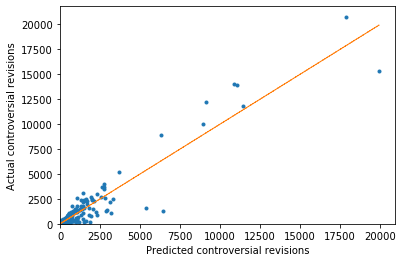

In [69]:
predicted = model.predict(X_valid)
plt.plot(predicted, y_valid,'.')
m, b = np.polyfit(predicted, y_valid, 1)
plt.plot(predicted, predicted,'--',linewidth=1)
plt.plot()
plt.xlabel('Predicted controversial revisions')
plt.ylabel('Actual controversial revisions')
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.savefig('../../result/model_performance.png')
plt.show()

In [70]:
score = model.score(X_valid,y_valid)
print(score)

0.9015624948985629


In [71]:
with open('../../result/regression-model.pkl', 'wb') as fid:
    cPickle.dump(model, fid)

# get metrics for TCM

In [2]:
parquetdir = '../../tcm-columns-add-main/'

In [11]:
page_title = ddf.read_parquet(os.path.join(parquetdir,'page.title')).compute().drop(columns={'dir0'})

In [75]:
x = page_title['page.title'].unique()

In [ ]:
# get all TCM titles, and only read the folders contains the TCM articles

In [80]:
with open('../../intermediate-result/title-look-up.pickle', 'rb') as handle:
    title_lookup = pickle.load(handle)

In [82]:
def update_folder_title_info(title,folder):
    if folder in folder_title_info:
        folder_title_info[folder].append(title)
    else:
        folder_title_info[folder] = [title]

In [84]:
for title in x:
    folder = title_lookup[title]
    update_folder_title_info(title,folder)

In [85]:
all_files = folder_title_info.keys()

In [87]:
data = pd.DataFrame()

In [88]:
for file in all_files:
    test = ddf.read_parquet(os.path.join(metric_path,file,'minor')).compute()
    test = test.loc[test.index.isin(x)]
    if test.empty:
        continue 
    test = test.join(ddf.read_parquet(os.path.join(metric_path,file,'revision.count')).compute())
    test = test.join(ddf.read_parquet(os.path.join(metric_path,file,'page.length')).compute())
    test = test.join(ddf.read_parquet(os.path.join(metric_path,file,'unique.editors')).compute())
    test = test.join(ddf.read_parquet(os.path.join(metric_path,file,'links.count')).compute())
    test = test.join(ddf.read_parquet(os.path.join(metric_path,file,'anon.edits')).compute())
    test = test.join(ddf.read_parquet(os.path.join(metric_path,file,'reverts_new')).compute())
    test.to_csv('../../intermediate-result/TCM/tcm_metrics.csv', mode='a', header=False)
    data = pd.concat([data,test])

# get c score for articles

In [3]:
data = pd.read_csv('../../intermediate-result/TCM/tcm_metrics.csv',names=['minor','revision.count','page.length',\
                                'unique.editors','links.count','anon.edits','reverts'])

In [4]:
article = data.loc[~data.index.str.startswith('Talk:')]
talk = data.loc[data.index.str.startswith('Talk:')]
talk.index = talk.index.str.replace('Talk:','')
talk.columns = ['talk.' + str(col) for col in talk.columns]
final = article.join(talk)

In [5]:
final = final.fillna(0).astype('int')

In [6]:
with open('../../result/regression-model.pkl', 'rb') as fid:
    model = cPickle.load(fid)
def estimate_crc(input_data):
    predict = model.predict(input_data)
    predict = round(predict[0],2)
    return 0 if predict < 0 else predict

In [7]:
final['estimated_crc'] = final.apply(lambda df: estimate_crc([[df['revision.count'],df['page.length'],df['unique.editors'],
        df['links.count'],df['anon.edits'],df['minor'],df['reverts'],df['talk.revision.count'],df['talk.page.length'],
        df['talk.unique.editors'],df['talk.links.count'],df['talk.anon.edits'],df['talk.minor']]]),axis=1)

In [8]:
final['estimated_crc_normalized'] = final['estimated_crc']/final['estimated_crc'].max()

# get c score for editors

In [9]:
crc_dict = final['estimated_crc'].to_dict()
crc_dict_n = final['estimated_crc_normalized'].to_dict()

In [12]:
def is_talk(text):
    return re.search('Talk:', text) != None

In [13]:
revisions = final['revision.count'].to_dict()

In [14]:
selected_editors = pd.read_parquet('../../intermediate-result/TCM/editors-with-sig-contrib-at-least-10').index

In [15]:
user_contribution = pd.read_parquet('../../intermediate-result/TCM/sig-contrib-info')

In [19]:
user_contribution = user_contribution[~user_contribution['page.title'].apply(is_talk)]

In [20]:
user_contribution = user_contribution.groupby(['contributor.username','page.title']).sum()

In [21]:
res = {}
res_normalized ={}

In [22]:
for user in selected_editors:
    if user not in user_contribution.index.get_level_values(0):
        res[user] = 0
        continue
    contributions = user_contribution.loc[user]
    contributions = contributions.to_dict()['sig.contributions']
    c = 0
    c_n = 0
    for key,val in contributions.items():
        crc = crc_dict[key]
        crc_n = crc_dict_n[key]
        c += crc * val/revisions[key]
        c_n += crc_n * val/revisions[key]
    res[user] = c
    res_normalized[user] = c_n

In [24]:
res_df = pd.DataFrame(res.items(), columns=['contributor', 'c_score']).set_index('contributor')
res_n_df = pd.DataFrame(res_normalized.items(), columns=['contributor', 'c_score_normalized']).set_index('contributor')

In [26]:
res_df.to_csv("../../result/TCM/TCM-CScore-user.tsv", sep="\t",encoding='utf-16')

In [27]:
article_crc = final[['estimated_crc']]

In [28]:
article_crc.to_csv("../../result/TCM/TCM-CScore-article.tsv", sep="\t",encoding='utf-16')

In [29]:
res_df.to_parquet('../../result/TCM/TCM-CScore-user.parquet')

In [30]:
article_crc.to_parquet('../../result/TCM/TCM-CScore-article.parquet')

In [31]:
final.to_parquet('../../intermediate-result/TCM/TCM-article-info.parquet')

In [33]:
article_crc_norm = final[['estimated_crc_normalized']]

In [34]:
article_crc_norm.to_parquet('../../result/TCM/TCM-normalized-CScore-article.parquet')

In [35]:
res_n_df.to_parquet('../../result/TCM/TCM-normalized-CScore-user.parquet')